In [1]:
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPool2D,Flatten

from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau,EarlyStopping


In [2]:
def segmentation(frame,thresshold=30):
    global background
    
    difference = cv2.absdiff(background.astype("uint8"), frame)
    _,processed_frame=cv2.threshold(difference,thresshold,255,cv2.THRESH_BINARY)
    contours,_=cv2.findContours(processed_frame,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        contour = max(contours,key = cv2.contourArea)
    return (processed_frame,contour)

In [150]:
cam = cv2.VideoCapture(0)

#roi - region of interest
top=50
bottom=300
right=50
left=250
    
    
background=None
count = 0

digit=0

sample_number=0
while True: 
    value , frame = cam.read()
    framecopy=frame.copy()
    framecopy=cv2.flip(framecopy,1)
    roi = framecopy[top:bottom,right:left]
    roi_gray=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    roi_gray=cv2.GaussianBlur(roi_gray,(9,9),0)
    
    if background is None:
        background = roi_gray.copy().astype('float')
    
    
    
    cv2.rectangle(framecopy,(left,top),(right,bottom),(0,0,255),3)
    if count < 30:
        cv2.accumulateWeighted(roi_gray,background,0.5)
        cv2.putText(framecopy,'Loading...',(280,200),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)

    collection = segmentation(roi_gray)
    k = cv2.waitKey(1)

    if collection is not None:
        roi_processed,contour=collection
        cv2.drawContours(framecopy,[contour+(right,top)],-1,(0,255,0),3)
        
        if k == ord(" "):
            cv2.putText(framecopy,str(sample_number)+' Gesture('+str(digit)+' )',(70,45),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
            cv2.imwrite("D:/acpc/train_/"+str(digit)+'/'+str(digit)+'-'+str(sample_number)+'.jpg',roi_processed)
            sample_number+=1
            
        cv2.imshow('Segmantation',roi_processed)
        
    cv2.putText(framecopy,'Gesture( '+str(digit)+' )',(50,340),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),1)

    cv2.imshow('Camera',framecopy)

    count+=1
    if k == 27:
        break
    elif k == 13:
        digit = (digit+1) % 11
        sample_number=0
        
        
        
    
cv2.destroyAllWindows()
cam.release()

In [3]:
train_data_path="D:/hema/asl_dataset"
train_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_data_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)


Found 7154 images belonging to 10 classes.


In [4]:
images_train , labels_train = next(train_data_batches)

In [5]:
test_data_path = "D:/hema/test"
test_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_data_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)


Found 2810 images belonging to 10 classes.


In [6]:
images_test , labels_test = next(test_data_batches)

In [7]:
def display(images):
    fig,axes = plt.subplots(1,10,figsize=(30,20))
    for image ,ax in zip(images,axes):
        image=np.clip(image,0,1)
        ax.imshow(image)
        ax.axis('off')
        
    plt.tight_layout
    plt.show()

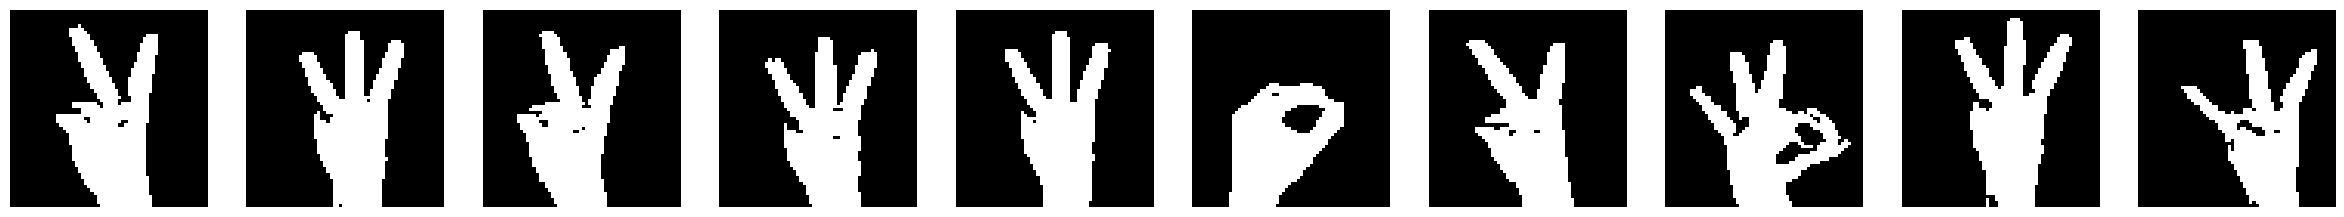

In [8]:
display(images_train)

In [9]:
words = {0:'zero',1:'one',2:'two',3:'three',4:'four',5:'five',6:'sex',7:'seven',8:'eight',9:'nine',10:'ten'}

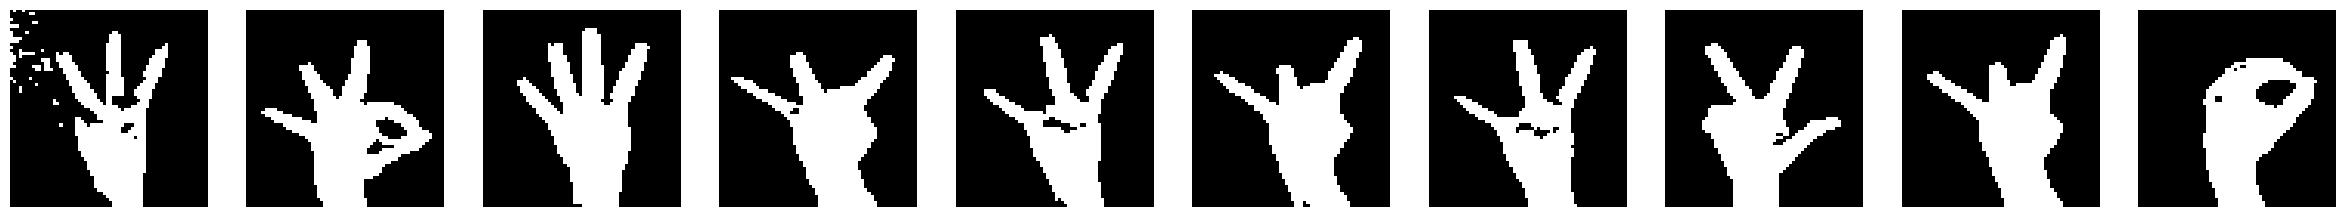

sex nine four eight seven eight seven three eight zero 

In [10]:
display(images_test)

def digits(labels):
    for label in labels:
        print(words[np.argmax(label)],end=" ")
        
digits(labels_test)

In [159]:
def createModel():
    model = Sequential()
    
    model.add(Conv2D(filters=32,kernel_size=(3,3), activation='relu',input_shape=(64,64,3)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
        
    model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu',padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(64,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    
    return model

model=createModel()



In [160]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=1,mode='auto',verbose=0)

In [161]:
model.fit(train_data_batches,epochs=10,callbacks=[reduceLR,early_stop],validation_data=test_data_batches)

Epoch 1/10
716/716 [==============================] - 30s 40ms/step - loss: 0.3794 - accuracy: 0.9388 - val_loss: 0.0141 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 29s 40ms/step - loss: 0.1123 - accuracy: 0.9788 - val_loss: 0.0401 - val_accuracy: 0.9879 - lr: 0.0010


In [162]:
score = model.evaluate(images_test,labels_test,verbose=0)
print(f'{model.metrics_names[0]} = {score[0]} || {model.metrics_names[1]} = {score[1]*100}%')

loss = 0.02113240770995617 || accuracy = 100.0%


In [3]:
model.save('D:\Signdigits2.h5')


NameError: name 'model' is not defined

In [11]:
model4 = tf.keras.models.load_model('D:\Signdigits2.h5')

In [37]:
cam = cv2.VideoCapture(0)
#roi - region of interest
top=50
bottom=300
right=50
left=250
    
    
background=None
count = 0

digit=0

sample_number=0
while True: 
    value , frame = cam.read()
    framecopy=frame.copy()
    framecopy=cv2.flip(framecopy,1)
    roi = framecopy[top:bottom,right:left]
    roi_gray=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    roi_gray=cv2.GaussianBlur(roi_gray,(9,9),0)
    
    if background is None:
        background = roi_gray.copy().astype('float')
    
    
    
    cv2.rectangle(framecopy,(left,top),(right,bottom),(0,0,255),3)
    if count < 30:
        cv2.accumulateWeighted(roi_gray,background,0.5)
        cv2.putText(framecopy,'Loading...',(280,200),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)

    collection = segmentation(roi_gray)
    k = cv2.waitKey(1)

    if collection is not None:
        roi_processed,contour=collection
        cv2.drawContours(framecopy,[contour+(right,top)],-1,(0,255,0),3)
        
        roi_processed = cv2.resize(roi_processed,(64,64))
        roi_processed = cv2.cvtColor(roi_processed,cv2.COLOR_GRAY2RGB)
        frame = np.reshape(roi_processed,(1,roi_processed.shape[0],roi_processed.shape[1],3))
        
        value = model4.predict(frame)
        label = words[np.argmax(value)]
        cv2.putText(framecopy,str(label),(370,145),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
        if k == ord(" "):
            cv2.putText(framecopy,str(sample_number)+' Gesture('+str(digit)+' )',(70,45),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
            cv2.imwrite("D:/hema/asl_dataset/"+str(digit)+'/'+str(digit)+'-'+str(sample_number)+'.jpg',roi_processed)
            sample_number+=1
            
        cv2.imshow('Segmantation',roi_processed)
        
    cv2.putText(framecopy,'Gesture( '+str(digit)+' )',(50,340),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),1)

    cv2.imshow('Camera',framecopy)

    count+=1
    if k == 27:
        break
    elif k == 13:
        digit = (digit+1) % 11
        sample_number=0
        
        
    
cv2.destroyAllWindows()
cam.release()

1/1 [==============================] - 0s 14ms/step
